In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate

from scipy.fftpack import fft, ifft, fftn, ifftn
from scipy.signal import periodogram, hamming, tukey
import scipy.stats as stats


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Reading in data for hmix=5:

In [2]:
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
# fs_025 = xr.open_dataset('static.nc', decode_times=False)
# av_025 = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# #sn_025 = xr.open_dataset('snapshots_00031505.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
# fs_0125 = xr.open_dataset('static.nc', decode_times=False)
# av_0125 = xr.open_dataset('averages_00004502.nc', decode_times=False)
# #sn_0125 = xr.open_dataset('snapshots_00004505.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
fs_00625 = xr.open_dataset('static.nc', decode_times=False)
av_00625 = xr.open_dataset('averages_00004502.nc', decode_times=False)
#sn_00625 = xr.open_dataset('snapshots_00004505.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5/
# fs_003125 = xr.open_dataset('static.nc', decode_times=False)
# av_003125 = xr.open_dataset('averages_00002702.nc', decode_times=False)
# #sn_003125 = xr.open_dataset('snapshots_00002705.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.0625deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


### Reading in data for 0.5 degree and parameterized runs

In [3]:
##Unparameterized run
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
fs_05 = xr.open_dataset('static.nc', decode_times=False)
os_05 = xr.open_dataset('ocean.stats.nc', decode_times=False)
av_05 = xr.open_mfdataset('averages_00031502.nc', decode_times=False)   



%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS02_COEF07/
test1 = xr.open_dataset('averages_00031502.nc', decode_times=False)  

%cd /glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1/
test2 =  xr.open_dataset('averages_00031502.nc', decode_times=False)  

#Contains default setup based on Jansen et al 2019. MEKE_VISCOSITY_COEFF_KU = -0.15; MEKE_KHCOEFF = 0.15
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default/
av_05_GMBS =  xr.open_dataset('averages_00031502.nc', decode_times=False)  

## MEKE_VISCOSITY_COEFF_KU = -0.3; MEKE_KHCOEFF = 0.0
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
av_05_BS =  xr.open_dataset('averages_00031502.nc', decode_times=False)    

## MEKE_VISCOSITY_COEFF_KU = -0; MEKE_KHCOEFF = 0.5
%cd /glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7
av_05_GM =  xr.open_dataset('averages_00031502.nc', decode_times=False)  


/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/default_noparameterization
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS02_COEF07
/glade/scratch/eyankovsky/Backscatter_tests_with_Scott/Half_degree/05deg_KS025_COEF1
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_GM_BS_default
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test16
/glade/p/univ/unyu0004/eyankovsky/MEKE_testing/MEKE_test7


In [4]:
grid_05= Grid(av_05, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                       'Y': {'center': 'yh', 'outer': 'yq'}});
# grid_025= Grid(av_025, coords={'X': {'center': 'xh', 'outer': 'xq'},
#                         'Y': {'center': 'yh', 'outer': 'yq'}});
# grid_0125= Grid(av_0125, coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'}});
grid_00625= Grid(av_00625, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'}});
# grid_003125= Grid(av_003125, coords={'X': {'center': 'xh', 'outer': 'xq'}, 
#                         'Y': {'center': 'yh', 'outer': 'yq'}});


# #Interpolating surface u,v to be on the same grid points. Using only 100 days, or 20 time steps:
# dx_05= grid_05.interp(fs_05.dxCu,axis='X'); dy_05= grid_05.interp(fs_05.dyCv,axis='Y')

u_05 = grid_05.interp(av_05.u,axis='X');
v_05 = grid_05.interp(av_05.v,axis='Y'); 
dzt_05  = av_05.h

u_05_BS = grid_05.interp(av_05_BS.u,axis='X');
v_05_BS = grid_05.interp(av_05_BS.v,axis='Y'); 
dzt_05_BS  = av_05_BS.h

u_05_GM = grid_05.interp(av_05_GM.u,axis='X');
v_05_GM = grid_05.interp(av_05_GM.v,axis='Y'); 
dzt_05_GM  = av_05_GM.h

u_05_GMBS = grid_05.interp(av_05_GMBS.u,axis='X');
v_05_GMBS = grid_05.interp(av_05_GMBS.v,axis='Y'); 
dzt_05_GMBS  = av_05_GMBS.h

u_test1 = grid_05.interp(test1.u,axis='X');
v_test1 = grid_05.interp(test1.v,axis='Y'); 
dzt_test1  = test1.h

u_test2 = grid_05.interp(test2.u,axis='X');
v_test2 = grid_05.interp(test2.v,axis='Y'); 
dzt_test2  = test2.h

# dx_025= grid_025.interp(fs_025.dxCu,axis='X'); dy_025= grid_025.interp(fs_025.dyCv,axis='Y')
# u_025 = grid_025.interp(av_025.u,axis='X');
# v_025 = grid_025.interp(av_025.v,axis='Y'); 
# dzt_025  = av_025.h

# dx_0125= grid_0125.interp(fs_0125.dxCu,axis='X'); dy_0125= grid_0125.interp(fs_0125.dyCv,axis='Y')
# u_0125 = grid_0125.interp(av_0125.u,axis='X');
# v_0125 = grid_0125.interp(av_0125.v,axis='Y'); 
# dzt_0125  = av_0125.h#.fillna(0.)

dx_00625= grid_00625.interp(fs_00625.dxCu,axis='X'); dy_00625= grid_00625.interp(fs_00625.dyCv,axis='Y')
u_00625 = grid_00625.interp(av_00625.u,axis='X');
v_00625 = grid_00625.interp(av_00625.v,axis='Y'); 
dzt_00625  = av_00625.h#.fillna(0.)


# dx_003125= grid_003125.interp(fs_003125.dxCu,axis='X'); dy_003125= grid_003125.interp(fs_003125.dyCv,axis='Y')
# u_003125 = grid_003125.interp(av_003125.u,axis='X')#.fillna(0.); 
# v_003125 = grid_003125.interp(av_003125.v,axis='Y')#.fillna(0.);
# dzt_003125  = av_003125.h#.fillna(0.)
print('done')

done


## Defining functions based on Kjellsson & Zanna (2017): 
https://github.com/joakimkjellsson/spectre
  

In [5]:
def set_wavenumbers(x0,x1,y0,y1,dx,dy,nx,ny,grid='ll'):
   """
   Set wavenumber arrays given x,y min/max, grid size and resolution
   If grid='ll' (default) it is assumed we have a lon-lat grid
   If grid='xy' we are on a x-y grid
   
   Input:
     x0 - minimum x value (e.g. westernmost longitude)
     x1 - maximum x value (e.g. easternmost longitude)
     y0 - minimum y value (e.g. southern boundary)
     y1 - maximum y value (e.g. northern boundary)
     dx - grid resolution (in degrees if lon-lat or meter if xy)
     dy - meridional resolution
     nx - number of zonal points
     ny - number of meridional points
     
   Output:
     xx, yy - 2D arrays with x,y points on a regular grid
              Can be used if you want to interpolate to this grid
     wn_x, wn_y - 1D arrays of zonal and meridional wavenumbers
     kx, ky - 2D arrays of zonal and meridional wavenumber
     k - 1D array of isotropic wavenumber
     dk - Resolution of k wavenumber array
   
   """
   
   if grid == 'xy':
      ## Set x,y arrays that are monotonic
      xmin = 0
      xmax = x1-x0
      ymin = 0
      ymax = y1-y0
   
      ## Length of domain
      Lx = np.abs(xmax - xmin)
      Ly = np.abs(ymax - ymin)
      
      x = np.arange(x0,x1,nx)
      y = np.arange(y0,y1,ny)
   
   if grid == 'll':
      xmin = x0
      xmax = x1
      ymin = y0
      ymax = y1
      
      # if xmax less than xmin,
      # e.g. xmax = -160 and xmin = 160
      # then add 360 degrees
      if (xmax <= xmin): xmax=xmax+360
      # by checking above, we have 
      # ensured x below is monotonic      
      x = xmin + np.arange(0,nx) * dx
      
      y = ymin + np.arange(0,ny) * dy
      
      ## size of domain in meters
      mean_lat = (y1+y0)/2.
      Lx = 6731000. * (x.max() - x.min()) / 180. * np.pi * np.cos(mean_lat * np.pi/180.)
      Ly = 6731000. * (y.max() - y.min()) / 180. * np.pi
      #print 'Lx,Ly [deg] ',x.max()-x.min(),y.max()-y.min()
      
      # now remove 360 where x > 180 go get 
      # back to original definition
      x = np.where(x>=180,x-360,x)
   
   ## 2D arrays of coordinates   
   xx,yy = np.meshgrid(x,y)
      
   #print 'Lx,Ly [meter]',Lx,Ly
      
   ## Wavenumber vectors
   ## Depend if nx,ny are even or odd numbers
   if (np.mod(nx,2) == 0):
      wn_x = 2.0 * np.pi / Lx * \
             np.concatenate( (np.arange(0,nx/2+1),np.arange(-nx/2+1,0)) )
   else:
      nnx = (nx-1)/2
      wn_x = 2.0 * np.pi / Lx * \
             np.concatenate( (np.arange(0,nnx+1),np.arange(-nnx,0)) )
   if (np.mod(ny,2) == 0):   
      wn_y = 2.0 * np.pi / Ly * \
             np.concatenate( (np.arange(0,ny/2+1),np.arange(-ny/2+1,0)) )       
   else:
      nny = (ny-1)/2
      wn_y = 2.0 * np.pi / Ly * \
             np.concatenate( (np.arange(0,nny+1),np.arange(-nny,0)) )        
   
   ## 2D wavenumber arrays
   kx,ky = np.meshgrid(wn_x,wn_y)
   ## Square total wavenumber
   wvsq  = kx**2 + ky**2
   ## Maximum wavenumber
   wn_max = np.max( np.sqrt(wvsq) )
   
   ## Make an isotropic 1D wavenumber array
   dk = min(2.0*np.pi/Lx,2.0*np.pi/Ly)
   k = np.arange(dk,wn_max+dk,dk)
   nk = k.shape[0]
   
   return xx,yy,wn_x,wn_y,kx,ky,wvsq,k,dk


def calculate_spectral_flux_3D(kx,ky,uvel,vvel,dzt):
   """
   Calculate spectral flux
   Used in Kjellsson & Zanna (Fluids, 2017)
   A good reference for the terms is Scott & Arbic (JPO, 2007)
   

   Input: 
      kx, ky - 2D arrays with zonal and meridional wavenumbers
      u, v - 3D arrays with velocity components
      dudt, dvdt - 3D arrays with time tendencies for momentum equations
      dzt - 3D thickness array
   
   """
   
   i = np.complex(0,1)

   
   nx = uvel.shape[2]
   ny = uvel.shape[1]
   nz = uvel.shape[0]
   
   #adv_u_tot = np.zeros((ny,nx))
   #adv_v_tot = np.zeros((ny,nx))
   Tkxky     = np.zeros((ny,nx))
   #Tkxky_alt = np.zeros((ny,nx))
 
   Hsum = np.sum(dzt,axis=0)
   
   for jk in range(0,nz):
      uhat = fftn(uvel[jk,:,:])
      vhat = fftn(vvel[jk,:,:])

      # du/dx in x,y
      ddx_u = np.real( ifftn(i*kx*uhat) )
      # du/dy in x,y
      ddy_u = np.real( ifftn(i*ky*uhat) )
      # dv/dx in x,y
      ddx_v = np.real( ifftn(i*kx*vhat) )
      # dv/dy in x,y
      ddy_v = np.real( ifftn(i*ky*vhat) )
   
      # adv_u = u * du/dx + v * du/dy
      # weight by layer thickness

      adv_u = (-uvel[jk,:,:] * ddx_u - vvel[jk,:,:] * ddy_u) * dzt[jk,:,:]/Hsum
      # adv_v = u * dv/dx + v * dv/dy
      adv_v = (-uvel[jk,:,:] * ddx_v - vvel[jk,:,:] * ddy_v) * dzt[jk,:,:]/Hsum
   
      # KE trend from advection: 
      # - u * adv_u - v * adv_v
      # in spectral space
      # The minus sign arises as advection 
      # is on the RHS of the momentum eqs. 
      Tkxky = Tkxky + np.real( np.conj(uhat)*fftn(adv_u) + \
                   np.conj(vhat)*fftn(adv_v) )   #[m2/s3]
   

   ## The FFT routine in scipy returns
   ## y(j) = (x * exp(-2*pi*sqrt(-1)*j*np.arange(n)/n)).sum()
   ## where j is wavenumber, x is array in gridpoint space, and n is number of grid points
   ## To normalise, we must divide by n
   ## if its a 2D FFT, we must divide by nx*ny
   ## and since we take the square of the transformed variables
   ## we must divide by (nx*ny)^2
   nn2 = (nx**2 * ny**2)                        
   
   
   Tkxky = Tkxky / float(nn2)
   #Tkxky_alt = Tkxky_alt / float(nn2)

   
   return Tkxky

def integrate_spectrum(psd2D,wvsq,k,dk):
   """
   """
   ## Integrate 2D PSD around lines of constant k
   ## sum(u^2 + v^2) = sum(E)
   ## PSD = d/dk sum(E) [m3/s2]
   ## E = PSD * dk [m2/s2], energy at a given k
   nk = k.shape[0]
   psc = np.zeros((nk))
   for jk in range(0,nk):
      indices = np.where(wvsq >= k[jk]**2)
      psc[jk] = np.sum(psd2D[indices]) 
         
   vpsd   = -(psc[1:] - psc[0:-1]) / dk    #units m2/s3  "transfer"
   #vpsdk  =  (psc[1:] + psc[0:-1]) * 0.5 
   vpsdk  =  psc[0:-1]                     #units m/s^3 "flux"
   
   return 0.5*(k[1:]+k[0:-1]),vpsd,vpsdk


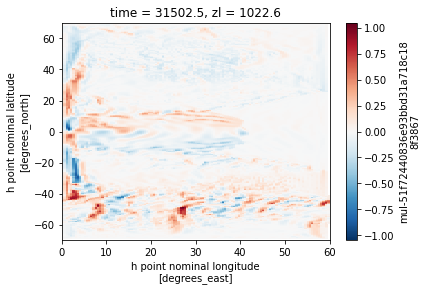

In [6]:
v_05[0,0,:].plot()

In [13]:
#Isolating region
#lat1 = 20; lat2 = 80; #ACC -- 30 to 60 south index 20 to 80
lat1 = 200; lat2 = 260; #North Atlantic -- 30 to 60 north
#lat1 = 5; lat2 = 275; #almost entire domain

lon1 = 30;  lon2 = 90; #index 5 to 115
v_05_region = v_05[:,:,lat1:lat2,lon1:lon2]-v_05[:,:,lat1:lat2,lon1:lon2].mean('time')
u_05_region = u_05[:,:,lat1:lat2,lon1:lon2]-u_05[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_05_region  = dzt_05[:,:,lat1:lat2,lon1:lon2]

v_GM_region = v_05_GM[:,:,lat1:lat2,lon1:lon2]-v_05_GM[:,:,lat1:lat2,lon1:lon2].mean('time')
u_GM_region = u_05_GM[:,:,lat1:lat2,lon1:lon2]-u_05_GM[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_GM_region  = dzt_05_GM[:,:,lat1:lat2,lon1:lon2]

v_GMBS_region = v_05_GMBS[:,:,lat1:lat2,lon1:lon2]-v_05_GMBS[:,:,lat1:lat2,lon1:lon2].mean('time')
u_GMBS_region = u_05_GMBS[:,:,lat1:lat2,lon1:lon2]-u_05_GMBS[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_GMBS_region  = dzt_05_GMBS[:,:,lat1:lat2,lon1:lon2]

v_BS_region = v_05_BS[:,:,lat1:lat2,lon1:lon2]-v_05_BS[:,:,lat1:lat2,lon1:lon2].mean('time')
u_BS_region = u_05_BS[:,:,lat1:lat2,lon1:lon2]-u_05_BS[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_BS_region  = dzt_05_BS[:,:,lat1:lat2,lon1:lon2]

v_test1_region = v_test1[:,:,lat1:lat2,lon1:lon2]-v_test1[:,:,lat1:lat2,lon1:lon2].mean('time')
u_test1_region = u_test1[:,:,lat1:lat2,lon1:lon2]-u_test1[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_test1_region  = dzt_test1[:,:,lat1:lat2,lon1:lon2]

v_test2_region = v_test2[:,:,lat1:lat2,lon1:lon2]-v_test2[:,:,lat1:lat2,lon1:lon2].mean('time')
u_test2_region = u_test2[:,:,lat1:lat2,lon1:lon2]-u_test2[:,:,lat1:lat2,lon1:lon2].mean('time')
dzt_test2_region  = dzt_test2[:,:,lat1:lat2,lon1:lon2]

# v_025_region = v_025[:,:,lat1*2:lat2*2,lon1*2:lon2*2]-v_025[:,:,lat1*2:lat2*2,lon1*2:lon2*2].mean('time')
# u_025_region = u_025[:,:,lat1*2:lat2*2,lon1*2:lon2*2]-u_025[:,:,lat1*2:lat2*2,lon1*2:lon2*2].mean('time')
# dzt_025_region  = dzt_025[:,:,lat1*2:lat2*2,lon1*2:lon2*2]


# v_0125_region = v_0125[:,:,lat1*4:lat2*4,lon1*4:lon2*4]-v_0125[:,:,lat1*4:lat2*4,lon1*4:lon2*4].mean('time')
# u_0125_region = u_0125[:,:,lat1*4:lat2*4,lon1*4:lon2*4]-u_0125[:,:,lat1*4:lat2*4,lon1*4:lon2*4].mean('time')
# dzt_0125_region  = dzt_0125[:,:,lat1*4:lat2*4,lon1*4:lon2*4]

v_00625_region = v_00625[:,:,lat1*8:lat2*8,lon1*8:lon2*8]-v_00625[:,:,lat1*8:lat2*8,lon1*8:lon2*8].mean('time')
u_00625_region = u_00625[:,:,lat1*8:lat2*8,lon1*8:lon2*8]-u_00625[:,:,lat1*8:lat2*8,lon1*8:lon2*8].mean('time')
dzt_00625_region  = dzt_00625[:,:,lat1*8:lat2*8,lon1*8:lon2*8]


# v_003125_region = v_003125[:,:,lat1*16:lat2*16,lon1*16:lon2*16]-v_003125[:,:,lat1*16:lat2*16,lon1*16:lon2*16].mean('time')
# u_003125_region = u_003125[:,:,lat1*16:lat2*16,lon1*16:lon2*16]-u_003125[:,:,lat1*16:lat2*16,lon1*16:lon2*16].mean('time')
# dzt_003125_region  = dzt_003125[:,:,lat1*16:lat2*16,lon1*16:lon2*16]

print('done')

done


In [14]:
u_00625_region.shape

(100, 15, 480, 480)

## Defining wavenumbers

In [15]:
## Here we set the wavenumber arrays
            ## The code has only been used for grid='ll', i.e. lon-lat grid
            ## but it should be possible and in fact more accurate to use grid='xy'
#set_wavenumbers(x0,x1,y0,y1,dx,dy,nx,ny,grid='ll'):

xx_05,yy_05,wn_x_05,wn_y_05,kx_05,ky_05,wvsq_05,k_05,dk_05 = set_wavenumbers(np.min(v_05_region.xh).values,np.max(v_05_region.xh).values,np.min(v_05_region.yh).values,\
                                                                                                                np.max(v_05_region.yh).values, 0.5,0.5,len(v_05_region.xh),len(v_05_region.yh),grid='ll')

# xx_025,yy_025,wn_x_025,wn_y_025,kx_025,ky_025,wvsq_025,k_025,dk_025 = set_wavenumbers(np.min(v_025_region.xh).values,np.max(v_025_region.xh).values,np.min(v_025_region.yh).values,\
#                                                                                                                  np.max(v_025_region.yh).values, 0.25,0.25,len(v_025_region.xh),len(v_025_region.yh),grid='ll')

# xx_0125,yy_0125,wn_x_0125,wn_y_0125,kx_0125,ky_0125,wvsq_0125,k_0125,dk_0125 = set_wavenumbers(np.min(v_0125_region.xh).values,np.max(v_0125_region.xh).values,np.min(v_0125_region.yh).values,\
#                                                                                                                 np.max(v_0125_region.yh).values, 0.125,0.125,len(v_0125_region.xh),len(v_0125_region.yh),grid='ll')

xx_00625,yy_00625,wn_x_00625,wn_y_00625,kx_00625,ky_00625,wvsq_00625,k_00625,dk_00625 = set_wavenumbers(np.min(v_00625_region.xh).values,np.max(v_00625_region.xh).values,np.min(v_00625_region.yh).values,\
                                                                                                                 np.max(v_00625_region.yh).values, 0.0625,0.0625,len(v_00625_region.xh),len(v_00625_region.yh),grid='ll')

# xx_003125,yy_003125,wn_x_003125,wn_y_003125,kx_003125,ky_003125,wvsq_003125,k_003125,dk_003125 = set_wavenumbers(np.min(v_003125_region.xh).values,np.max(v_003125_region.xh).values,np.min(v_003125_region.yh).values,\
#                                                                                                                  np.max(v_003125_region.yh).values, 0.03125,0.03125,len(v_003125_region.xh),len(v_003125_region.yh),grid='ll')
print('done')

done


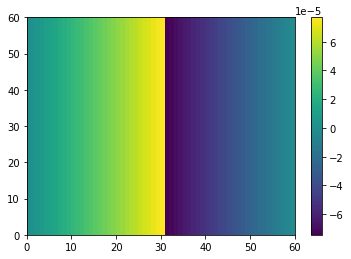

In [16]:
plt.pcolor(kx_05)
plt.colorbar()

In [17]:
timel = 100

Tk_final_05 = np.zeros([timel,51])
Tk_final_BS = np.zeros([timel,51])
Tk_final_GM = np.zeros([timel,51])
Tk_final_GMBS = np.zeros([timel,51])
Tk_final_test1 = np.zeros([timel,51])
Tk_final_test2 = np.zeros([timel,51])

Tk_final_00625 = np.zeros([timel,415])


for i in range(0,timel):
    
#     Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_05_region[i].values,v_05_region[i].values,dzt_05_region[i].values)
#     vk_05,Tk_final_05[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)
 
    Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_GMBS_region[i].values,v_GMBS_region[i].values,dzt_GMBS_region[i].values)
    vk_05,Tk_final_GMBS[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)

#     Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_GM_region[i].values,v_GM_region[i].values,dzt_GM_region[i].values)
#     vk_05,Tk_final_GM[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)

    Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_BS_region[i].values,v_BS_region[i].values,dzt_BS_region[i].values)
    vk_05,Tk_final_BS[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)
    
    Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_test1_region[i].values,v_test1_region[i].values,dzt_test1_region[i].values)
    vk_05,Tk_final_test1[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)
    
#     Tkxky = calculate_spectral_flux_3D(kx_05,ky_05,u_test2_region[i].values,v_test2_region[i].values,dzt_test2_region[i].values)
#     vk_05,Tk_final_test2[i,:],Pi_final = integrate_spectrum(Tkxky,wvsq_05,k_05,dk_05)
      
# #     Tkxky = calculate_spectral_flux_3D(kx_025,ky_025,u_025_region[i].values,v_025_region[i].values,dzt_025_region[i].values)
# #     vk_025,Tk_final_025[i,:],Pi_final_025[i,:] = integrate_spectrum(Tkxky,wvsq_025,k_025,dk_025)

# #     Tkxky = calculate_spectral_flux_3D(kx_0125,ky_0125,u_0125_region[i].values,v_0125_region[i].values,dzt_0125_region[i].values)
# #     vk_0125,Tk_final_0125[i,:],Pi_final_0125[i,:] = integrate_spectrum(Tkxky,wvsq_0125,k_0125,dk_0125)

    Tkxky = calculate_spectral_flux_3D(kx_00625,ky_00625,u_00625_region[i].values,v_00625_region[i].values,dzt_00625_region[i].values)
    vk_00625,Tk_final_00625[i,:],Pi_final_00625 = integrate_spectrum(Tkxky,wvsq_00625,k_00625,dk_00625)

#     Tkxky = calculate_spectral_flux_3D(kx_003125,ky_003125,u_003125_region[i,:].values,v_003125_region[i,:].values,dzt_003125_region[i,:].values)
#     vk_003125,Tk_final_003125[i,:],Pi_final_003125[i,:] = integrate_spectrum(Tkxky,wvsq_003125,k_003125,dk_003125)
    
    print(i)

print('done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done!


In [44]:
# fig, ax1 = plt.subplots(figsize=(10,6),dpi=100)
     

# ax1.set_title('Spectral flux: 30-60$^\circ$ S, 1/2$^\circ$ no parameterization')
# for i in range(0,20):
#     ax1.semilogx(vk_05,Pi_final_05[i,:],label='1/2$^\circ$')#,color='#8ecae6')
#     #ax1.semilogx(vk_025,Pi_final_025[i,:],label='1/4$^\circ$',color='#219ebc')
# # ax1.semilogx(vk_0125,Pi_final_0125.mean(axis=0),label='1/8$^\circ$',color='#023047')
# # ax1.semilogx(vk_00625,Pi_final_00625.mean(axis=0),label='1/16$^\circ$',color='#ffb703')
# # ax1.semilogx(vk_003125,Pi_final_003125.mean(axis=0),label='1/32$^\circ$',color='#fb8500')
# ax1.semilogx([1e-6,1e-3],[0,0],color='k')

# plt.xlim([1e-6, 1e-3]); 
# #plt.ylim([-1e-10, 1e-10]); 

# plt.grid()
# #plt.legend()
# #ax1.semilogx(vk_003125,Pi_final_003125*0,'k')

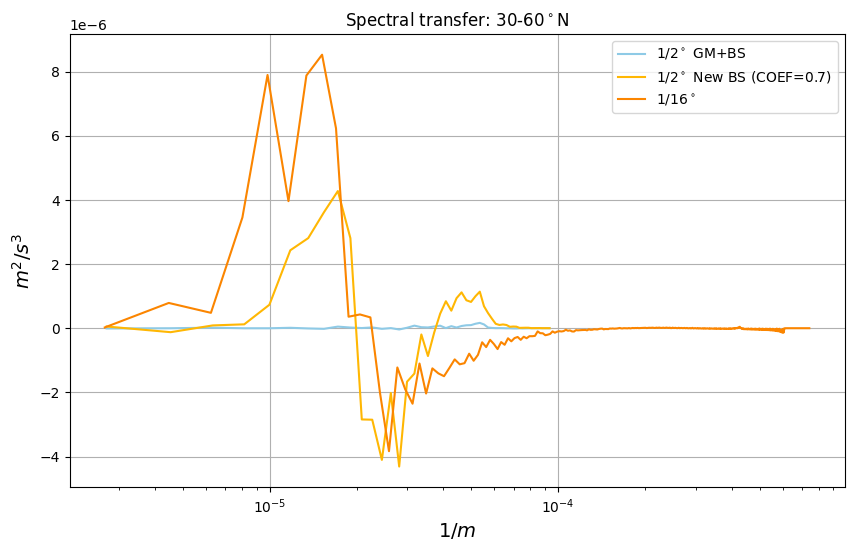

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6),dpi=100)
     

ax1.set_title('Spectral transfer: 30-60$^\circ$N')

ax1.semilogx(vk_05,Tk_final_GMBS.mean(axis=0),label='1/2$^\circ$ GM+BS',color='#8ecae6')
#ax1.semilogx(vk_05,Tk_final_BS.mean(axis=0),label='1/2$^\circ$ BS Only',color='#023047')
ax1.semilogx(vk_05,Tk_final_test1.mean(axis=0),label='1/2$^\circ$ New BS (COEF=0.7)',color='#ffb703')
ax1.semilogx(vk_00625,Tk_final_00625.mean(axis=0),label='1/16$^\circ$',color='#fb8500')
#ax1.semilogx([1e-6,1e-3],[0,0],color='k')

#plt.xlim([1e-6, 1e-3]); 
#plt.ylim([-15e-9, 15e-9]); 
plt.ylabel('$m^2/s^3$',fontsize=14)
plt.xlabel('$1/m$',fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.grid()
plt.legend()
#ax1.semilogx(vk_003125,Pi_final_003125*0,'k')

In [37]:
test=Tk_final_0125.mean(axis=0).shape

In [44]:
np.convolve(np.array(test), np.ones(10)/10, mode='valid').shape

(10,)

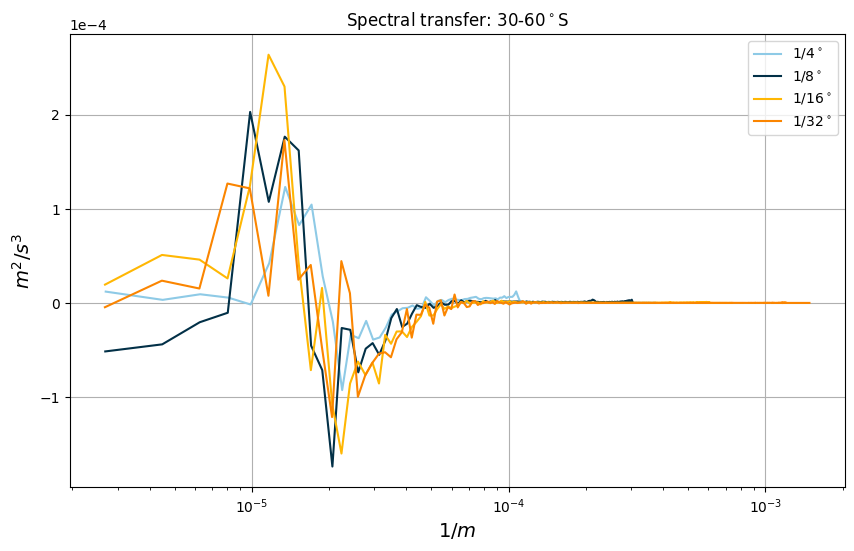

In [62]:
fig, ax1 = plt.subplots(figsize=(10,6),dpi=100)
     

ax1.set_title('Spectral transfer: 30-60$^\circ$S')

ax1.semilogx(vk_025,Tk_final_025.mean(axis=0),label='1/4$^\circ$',color='#8ecae6')
ax1.semilogx(vk_0125,Tk_final_0125.mean(axis=0),label='1/8$^\circ$',color='#023047')
ax1.semilogx(vk_00625,Tk_final_00625.mean(axis=0),label='1/16$^\circ$',color='#ffb703')
ax1.semilogx(vk_003125,Tk_final_003125.mean(axis=0),label='1/32$^\circ$',color='#fb8500')
#ax1.semilogx([1e-6,1e-3],[0,0],color='k')

#plt.xlim([1e-6, 1e-3]); 
#plt.ylim([-15e-9, 15e-9]); 
plt.ylabel('$m^2/s^3$',fontsize=14)
plt.xlabel('$1/m$',fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.grid()
plt.legend()
#ax1.semilogx(vk_003125,Pi_final_003125*0,'k')

In [ ]:
np.nansum(vk_003125*Pi_final_003125.mean(axis=0))

In [59]:
test = [0,1,2,3,4]
test[0:-1]

[0, 1, 2, 3]